In [238]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Importing Required Libraries

In [239]:
import numpy as np
from nltk.tokenize import word_tokenize
import pandas as pd
import glob 
import librosa
from sklearn.decomposition import PCA 
import imageio
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from scipy.stats import multivariate_normal
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Loading Movie Reviews

In [240]:
path = open('drive/MyDrive/Data/movieReviews.txt','r')
textFile = path.readlines()

Extracting the lables(0 or 1) from given reviews

In [241]:
labels = []
for i in textFile:
  i = i.strip()
  var = i.split("\t")
  labels.append(int(var[1]))
copyOfLables = []
for i in labels:
  copyOfLables.append(i)
labels = np.array(labels)


In [242]:
reviews = []
wordSet = set()

for line in textFile:
  x = []
  for i in word_tokenize(line):
    i = i.lower()
    if(i.isalpha()):
      x.append(i)
  reviews.append(x)
  for token in x:
    if token not in wordSet:
      wordSet.add(token)

totalDocument = len(reviews)


In [243]:
def getIndex(wordset):
  index = dict()
  itr = 0
  for i in wordSet:
    index[i] = itr
    itr += 1
  return index

In [244]:
index = getIndex(wordSet)
len(index)

3008

In [245]:
def getWordCount(wordset, reviewList):
  wordCount = dict()
  for i in wordSet:
    wordCount[i] = 0
    for j in reviews:
      if i in j:
        wordCount[i] +=1
  return wordCount

In [246]:
wordCount = getWordCount(wordSet, reviews)

print(len(wordCount))

3008


Calculating 'TermFrequency', 'InverseDocumentFrequency', and 'TermFrequency-InverseDocumentFrequency'

In [247]:
def termFreq(document,token):
  ans = []
  for i in document:
    if(i == token):
      ans.append(i)
  return len(ans)/len(document)

def idf(token):
  try:
    wordFrequency = wordCount[token] + 1
  except:
    wordFrequency = 1
  return np.log(1000/wordFrequency)

def tf_idf(doc):
  tf_idf = np.zeros((len(wordSet),))
  for token in doc:
    tf_idf[index[token]] = termFreq(doc,token) * idf(token)
  return tf_idf

    


Calculating TF-IDF vector

In [248]:
def getTfIdfVectore(reviews):
  tv = []
  for i in reviews:
    t = tf_idf(i)
    tv.append(t)
  return tv

In [249]:
TFIDFVector = getTfIdfVectore(reviews)
print(len(TFIDFVector))
TFIDFVector = np.array(TFIDFVector)

1000


In [250]:
features = np.array(np.mean(TFIDFVector, axis=1))

Applying PCA

In [251]:
pca = PCA(n_components = 10)
reducedTFIDFVector = pca.fit_transform(TFIDFVector)
reducedTFIDFVector = np.array(reducedTFIDFVector)

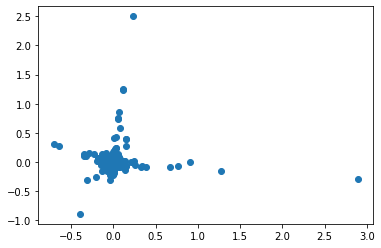

In [252]:
plt.scatter(reducedTFIDFVector[:,-1],reducedTFIDFVector[:,-2])
plt.show()

K-Mean

In [253]:
class KMean:
  def __init__(self, numberOfClusters , numberOfIteration = 1000):
    self.numberOfClusters = numberOfClusters
    self.numberOfIteration = numberOfIteration
    self.centers = None  



  def KMeanfit(self, musicFrames):
    it=0
    self.centers = musicFrames[np.random.choice(np.arange(len(musicFrames)), size = self.numberOfClusters)]
    for _ in range(self.numberOfIteration):
      it+=1
      distanceMatrix = np.zeros((len(musicFrames), self.numberOfClusters))
      for i in  range(self.numberOfClusters):
        distanceMatrix[:, i] = self.euclideanDistance(musicFrames, self.centers[i]) 
      clusterAssignment = distanceMatrix.argmin(axis=1)
      newCenters = np.zeros_like(self.centers)
      for i in range(self.numberOfClusters):
        newCenters[i] = np.mean(musicFrames[clusterAssignment == i], axis=0)
      if np.allclose(newCenters, self.centers):
        self.centers = newCenters
        break
      self.centers = newCenters
    print(it)
    return self.centers
          
  def KMeanpredict(self, musicFrames):
    distanceMatrix = np.zeros((len(musicFrames), self.numberOfClusters))
    for i in range(self.numberOfClusters):
      distanceMatrix[:, i] = self.euclideanDistance(musicFrames, self.centers[i]) 
    clusterAssignment = distanceMatrix.argmin(axis=1)
    return clusterAssignment

  def euclideanDistance(self, pointA, pointB):
    return np.sqrt(np.sum((pointA - pointB) ** 2, axis=1))

GMM

In [254]:
# numberOfMixtures = 2
# totalIterations = 50
# global alpha # = np.ones(numberOfMixtures) / numberOfMixtures
# logLikeliHoodList = []
# mv = KMeanfit(musicFrames)
# covariance = np.zeros((numberOfMixtures, musicFrames.shape[1], musicFrames.shape[1]))
# clusters = [f"cluster{i}" for i in range(numberOfMixtures)]
# alpha = np.ones(numberOfMixtures) / numberOfMixtures
class GMM:
  def __init__(self, numberOfMixtures, clusters = None, totalIterations = 1000, covarianceFlag = True):
    self.numberOfMixtures = numberOfMixtures
    self.totalIterations = totalIterations
    self.logLikeliHoodList = []
    self.covarianceFlag = covarianceFlag
    if clusters == None:
      temp = []
      for i in range(0, self.numberOfMixtures):
        temp.append("cluster" + str(i))
      self.cluster = temp
      # self.clusters = [f"cluster{index}" for index in range(self.numberOfMixtures)]
    else:
      self.clusters = clusters
    self.alpha = np.ones(numberOfMixtures) / numberOfMixtures
    
    

  def multivariateNormal(self, musicFrames, mean, covariance):
    a = multivariate_normal(mean=mean, cov=covariance, allow_singular=True)
    return a.pdf(musicFrames)


  def logLikelihood(self, musicFrames):
    # alpha = np.ones(numberOfMixtures) / numberOfMixtures
    p = np.zeros((len(musicFrames), self.numberOfMixtures))
    for i in range(self.numberOfMixtures):
      p[:, i] = self.alpha[i] * multivariate_normal(self.mv[i], self.covariance[i], allow_singular=True).pdf(musicFrames)
      # probs[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
      # p.append([multivariate_normal(mv[k], covariance[k]).pdf(musicFrames[n]) for k in range(numberOfMixtures)])
    likeliHood = np.sum(np.log(p.sum(axis=1)))
    return likeliHood


  def GMMfit(self, musicFrames):
    flag = 0
    # alpha = np.ones(numberOfMixtures) / numberOfMixtures
    KMeanObject = KMean(numberOfClusters = self.numberOfMixtures)
    self.mv = KMeanObject.KMeanfit(musicFrames)
    self.covariance = np.zeros((self.numberOfMixtures, musicFrames.shape[1], musicFrames.shape[1]))
    predictionKMean = KMeanObject.KMeanpredict(musicFrames)
    for i in range(self.numberOfMixtures):
      self.covariance[i] = np.cov(musicFrames[predictionKMean == i].T)
    for _ in range(self.totalIterations):


      self.temp = np.zeros((len(musicFrames), self.numberOfMixtures)) 
      # print(_)
      for i in range(self.numberOfMixtures):
        self.temp[:,i] = self.alpha[i] * (multivariate_normal(self.mv[i], self.covariance[i], allow_singular=True).pdf(musicFrames))
      self.logLikeliHoodList.append(np.sum(np.log(self.temp.sum(axis=1))))
      self.temp = self.temp / self.temp.sum(axis=1)[:, None]
      # self.logLikeliHoodList.append(np.sum(np.log(self.temp.sum(axis=1))))

      #Printing at every 5 reps
      if _ %2 ==0:          
        print("Scatter plot for iteration ", _)
        plt.scatter(musicFrames[self.temp[:,0]> self.temp[:,1],0],musicFrames[self.temp[:,0]> self.temp[:,1],1], color='b')
        plt.scatter(musicFrames[self.temp[:,0]<= self.temp[:,1],0],musicFrames[self.temp[:,0]<= self.temp[:,1],1], color='r')
        plt.xlim(-4,4,10)
        plt.ylim(-4,4,10)      
        plt.show()


      tmv = np.zeros_like(self.mv)
      for i in range(self.numberOfMixtures):
        tmv[i] = np.multiply(self.temp[:, i][:, None], musicFrames).sum(axis=0) / self.temp[: , i].sum()
      omv = self.mv
      self.mv = tmv
      covarinaceOld = self.covariance
      
      if(self.covarianceFlag == True):
        diagonalCovarinace = ((np.dot((self.temp.T), (musicFrames * musicFrames)) / self.temp.sum(axis=0)[:, None]) 
                              - 2 
                              * (self.mv * np.dot(self.temp.T, musicFrames) / self.temp.sum(axis=0)[:, None]) 
                              + (self.mv * self.mv) + 1e-6)
        self.covariance = [np.diag(c) for c in diagonalCovarinace]
      else:
        covarinaceNew = np.zeros_like(self.covariance)
        for i in range(self.numberOfMixtures):
          covarinaceNew[i] = np.dot(self.temp[:, i] * (musicFrames - self.mv[i]).T, (musicFrames - self.mv[i])) / self.temp[:, i].sum()    
          covarinaceNew[i].flat[::musicFrames.shape[1] + 1] += 1e-6
          self.covariance[i] = covarinaceNew[i]

      alphaOld = self.alpha
      self.alpha = self.temp.mean(axis=0)

      if np.allclose(self.alpha, alphaOld, rtol=1e-3, atol = 1e-3) and \
        np.allclose(self.covariance, covarinaceOld, rtol=1e-3, atol = 1e-3) and\
        np.allclose(self.mv, omv, rtol=1e-3, atol = 1e-3):
       
        break

  def GMMpredict(self, musicFrames):
    pos = []
    result = []
    for n in range(len(musicFrames)):
      pos.append([multivariate_normal(self.mv[k], self.covariance[k], allow_singular=True).pdf(musicFrames[n]) for k in range(self.numberOfMixtures)])  
    for p in pos:
      result.append(self.clusters[p.index(max(p))])
    return result


Two Mixture Model of Reduced Data with Diagonal Covariance

5
Scatter plot for iteration  0


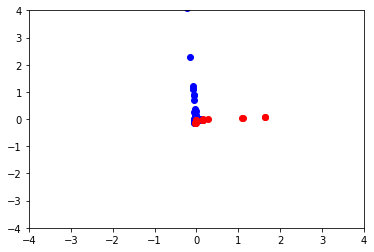

Scatter plot for iteration  2


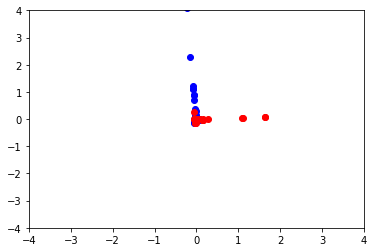

Scatter plot for iteration  4


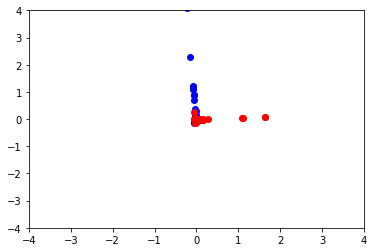

Scatter plot for iteration  6


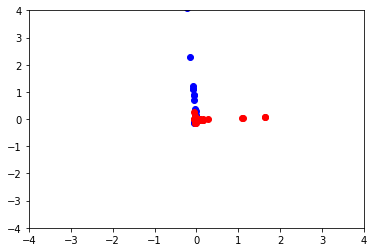

Scatter plot for iteration  8


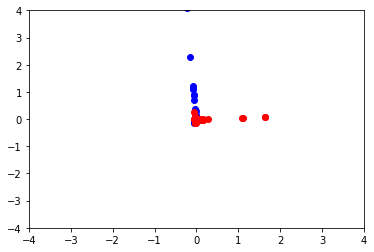

Scatter plot for iteration  10


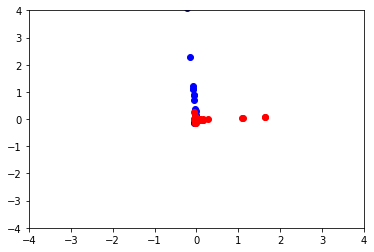

Scatter plot for iteration  12


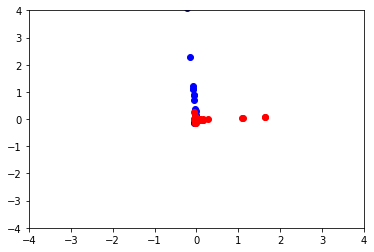

Scatter plot for iteration  14


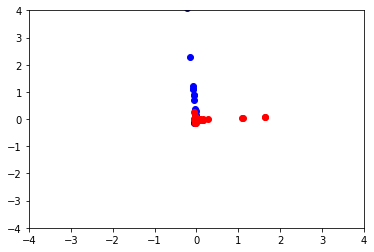

In [255]:
gmmObject = GMM(2)
gmmObject.GMMfit(reducedTFIDFVector)

Predicting the lables

In [256]:
prediction = []
for i in range(0, len(reviews)):
  if(gmmObject.temp[i,0] > gmmObject.temp[i,1]):
    prediction.append(1)
  else:
    prediction.append(0)
prediction = np.array(prediction)

Calculating the accuracy

In [257]:
correctnessCount = 0;
for i in range(0, len(copyOfLables)):
  if(copyOfLables[i] == prediction[i]):
    correctnessCount += 1
print(correctnessCount)

532
